Nuestra regla arbitraria fue que si almenos uno de los indicadores no coincidia en la decision de compra o de venta, no se tomaria, realizando el codigo de Best_Combination, descubrimos que la mejor combinacion con los mejores indicadores corresponde unicamente al indicador RSI

In [1]:
from prediction import def_trading_strategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("aapl_1d_train.csv")
rsi_data = ta.momentum.RSIIndicator(data.Close, window=14)
data["RSI"] = rsi_data.rsi()
data = data.dropna()

Encontramos que los mejores parametros del indicador fueron:

## RSI
Mejores parámetros encontrados:
{'n_shares': 36, 'stop_loss_close': 0.8493944230503813, 'take_profit_close': 1.3472201709899378, 'Umbral': 29.972576763871043}

Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).

optimal strategy: RSI
como funciona rsi?

la senal de trade es: si el precio de la accion es menor al 0.84*el ultimo close, compra, si el precio de la accion es mayor al 1.34*el ultimo close, vende. 
fue la mejor estrategia segun nuestro backtesting, el codigo de best_combination, y el que dio mejor profit

In [9]:
def def_trading_strategy(data, n_shares, stop_loss_close, take_profit_close, Umbral):
    cash= 1_000_000
    com = 0.125/100
    history = []
    portfolio_value = []
    active_operations = []
    total_profit_loss = 0

    for i, row in data.iterrows():
        # Close active operation
        active_op_temp = []
        for operation in active_operations:
            if operation["stop_loss"] > row.Close:
                cash += (row.Close * operation["n_shares"]) * (1 - com)
                # Calcular la ganancia o pérdida y actualizar el total
                profit_loss = (row.Close * operation["n_shares"]) * (1 - com) - (operation["bought"] * operation["n_shares"])
                total_profit_loss += profit_loss
                history.append({"profit_loss": profit_loss})
            elif operation["take_profit"] < row.Close:
                cash += (row.Close * operation["n_shares"]) * (1 - com)
                # Calcular la ganancia o pérdida y actualizar el total
                profit_loss = (row.Close * operation["n_shares"]) * (1 - com) - (operation["bought"] * operation["n_shares"])
                total_profit_loss += profit_loss
                history.append({"profit_loss": profit_loss})
            else:
                active_op_temp.append(operation)
        active_operations = active_op_temp
            
        # ¿Tenemos suficiente efectivo?
        if cash < (row.Close * n_shares * (1 + com)):
            asset_vals = sum([operation["n_shares"] * row.Close for operation in active_operations])
            portfolio_value.append(cash + asset_vals)
            continue
        
        # Analizar la señal larga
        if row.RSI <= Umbral:  # If ceil(Op)
            active_operations.append({
                "bought": row.Close,
                "n_shares": n_shares,
                "type": "long",
                "stop_loss": row.Close * stop_loss_close,
                "take_profit": row.Close * take_profit_close
            })
            cash -= row.Adjusted_close * n_shares * (1 + com)
        
        asset_vals = sum([operation["n_shares"] * row.Close for operation in active_operations])
        portfolio_value.append(cash + asset_vals)
    
    return total_profit_loss, portfolio_value

rsi, port_value=def_trading_strategy(data, 49, 0.93, 1.37, 10)

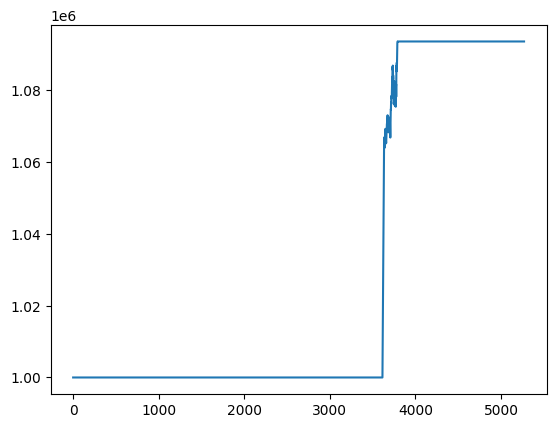

In [10]:
plt.plot(port_value)

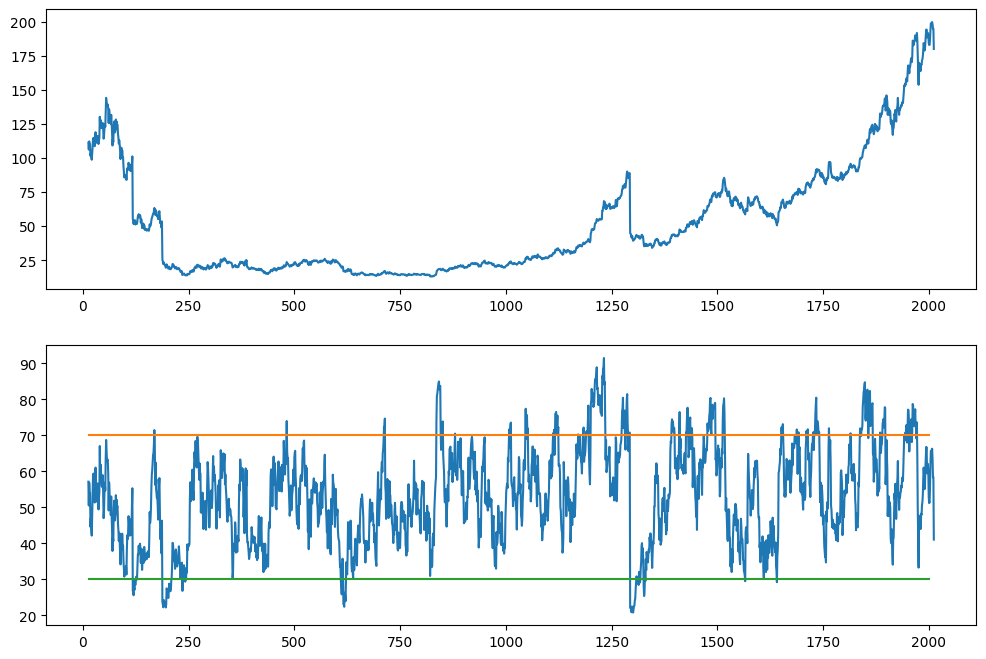

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(data.Close[:2000])
ax[1].plot(data.RSI[:2000])
ax[1].plot([14,2000], [70,70], label="Upper Threshold")
ax[1].plot([14,2000], [30,30], label="Lower Threshold")